In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import pickle

#### Load the model

##### Load the MLP

In [13]:
model_tags = ["RF_Z", "RF_Y", "LF_Z", "LF_Y", "LH_Z", "LH_Y", "RH_Z", "RH_Y"]
models = load_named_models(MLP, model_tags, base_path="./Model/", device='cpu')

In [14]:
models["RF_Z"]

MLP(
  (model): Sequential(
    (0): Linear(in_features=70, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=70, bias=True)
  )
)

##### Load the ESN

In [15]:
esn_rf, esn_lf, esn_lh, esn_rh = load_esn_models()

In [16]:
esn_rf

#### Load the data

In [17]:
data_for_train = np.load('./DataSet/data_for_train.npy')
period = 140

In [18]:
data_for_train.shape

(23940, 40)

#### Prediction

##### ESN prediction

In [19]:
rf_predicted = split_sequential_data(esn_rf.predict(data_for_train[:, 16:20]), period)
lf_predicted = split_sequential_data(esn_lf.predict(data_for_train[:, 20:24]), period)
lh_predicted = split_sequential_data(esn_lh.predict(data_for_train[:, 24:28]), period)
rh_predicted = split_sequential_data(esn_rh.predict(data_for_train[:, 28:32]), period)

# Extract target and split
rf_target = split_sequential_data(data_for_train[:, 32:34], period)
lf_target = split_sequential_data(data_for_train[:, 34:36], period)
lh_target = split_sequential_data(data_for_train[:, 36:38], period)
rh_target = split_sequential_data(data_for_train[:, 38:40], period)

In [20]:
rf_predicted.shape

(171, 140, 2)

In [21]:
rf_target.shape

(171, 140, 2)

In [22]:
rf_in,_ =split_signal_halves(rf_predicted)

In [23]:
rf_in.shape

(171, 70, 2)

##### MLP prediction

In [16]:
rf_in,_ = split_by_half_period(rf_predicted, period, 70,70)
lf_in,_ = split_by_half_period(lf_predicted, period, 70,70)
lh_in,_ = split_by_half_period(lh_predicted, period, 70,70)
rh_in,_ = split_by_half_period(rh_predicted, period, 70,70)

# split the sequential data to samples
# resplit to indiviual sample# select y to train as an example
'''Z'''
# rf
rf_in_z = reshape_to_samples(rf_in[:,0])
# lf
lf_in_z = reshape_to_samples(lf_in[:,0])
# lh
lh_in_z = reshape_to_samples(lh_in[:,0])
# rh
rh_in_z = reshape_to_samples(rh_in[:,0])

'''Y'''
# rf
rf_in_y = reshape_to_samples(rf_in[:,1])
# lf
lf_in_y = reshape_to_samples(lf_in[:,1])
# lh
lh_in_y = reshape_to_samples(lh_in[:,1])
# lh
rh_in_y = reshape_to_samples(rh_in[:,1])



In [17]:
rf_in_z.shape

(171, 70)

In [44]:
# rf signals 
RF_Z_latter_half = np.array([predict(x, models["RF_Z"]) for x in rf_in_z])
RF_Y_latter_half = np.array([predict(x, models["RF_Y"]) for x in rf_in_y])

In [25]:
RF_Z_latter_half.shape

(171, 70)

#### Plot the signal

In [42]:
rf_target.shape

(171, 140, 2)

In [41]:
RF_Z_latter_half.shape

(171, 70)

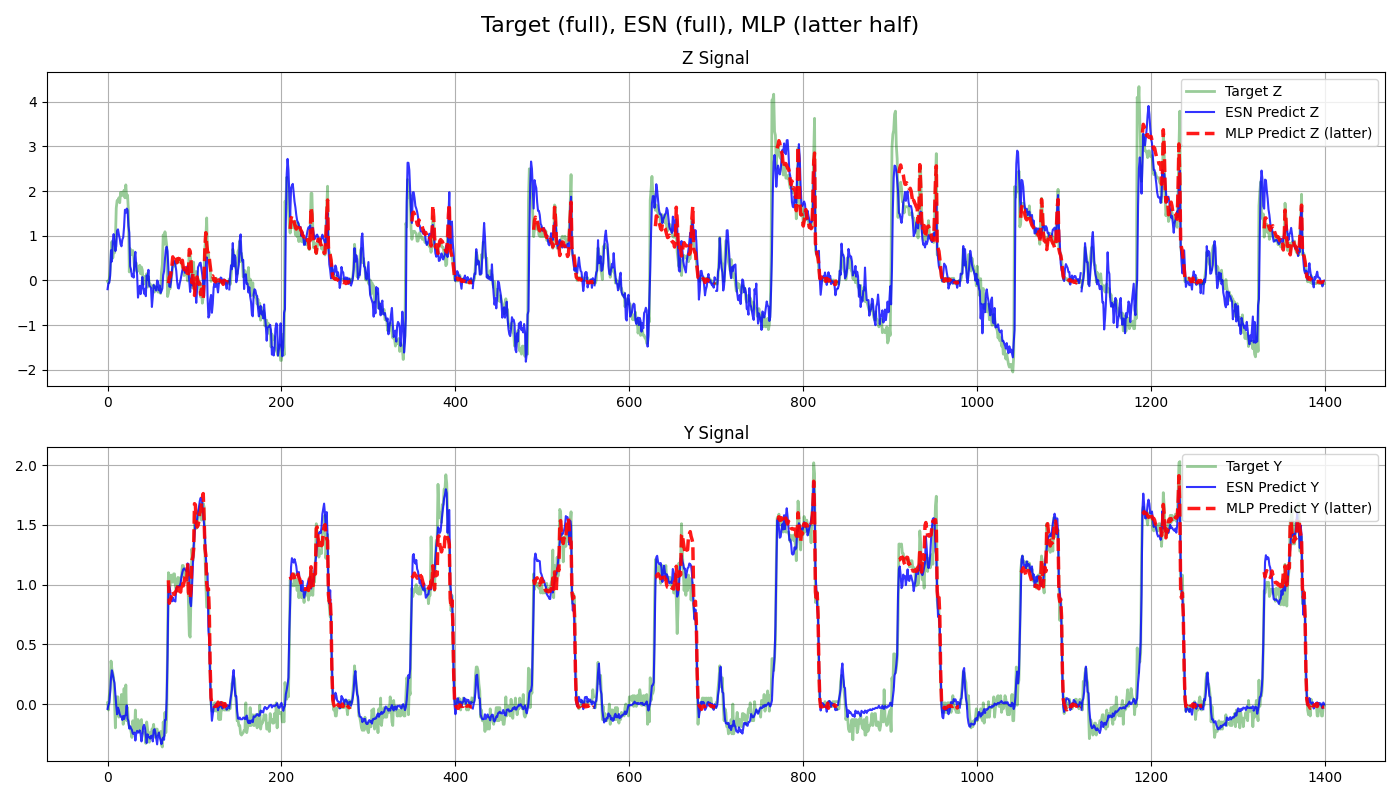

In [69]:
plot_prediction_signals(rf_predicted, RF_Y_latter_half, RF_Z_latter_half, rf_target)

In [2]:
def plot_prediction_signals(esn_predict, mlp_predict_y, mlp_predict_z, target, num_samples=10):
    """
    Plot 10 random samples on a shared timeline:
    - Target: full cycle (140 steps), vivid green, thick and transparent
    - ESN: full cycle (140 steps), blue
    - MLP: latter half only (70–139), red dashed and thick

    Parameters:
    - esn_predict: (n_samples, 140, 2)
    - mlp_predict_y: (n_samples, 70)
    - mlp_predict_z: (n_samples, 70)
    - target: (n_samples, 140, 2)
    """
    n_samples = esn_predict.shape[0]
    sample_indices = np.random.choice(n_samples, size=num_samples, replace=False)

    fig, axs = plt.subplots(2, 1, figsize=(14, 8))
    fig.suptitle("Target (full), ESN (full), MLP (latter half)", fontsize=16)

    # Fixed color styles
    color_target = 'green'
    color_esn = 'blue'
    color_mlp = 'red'

    for i, idx in enumerate(sample_indices):
        start = i * 140
        end = start + 140
        mid = start + 70
        time_full = np.arange(start, end)
        time_second_half = np.arange(mid, end)

        # Z signal
        axs[0].plot(time_full, target[idx, :, 0],
                    color=color_target, alpha=0.4, linewidth=2, label='Target Z' if i == 0 else "")
        axs[0].plot(time_full, esn_predict[idx, :, 0],
                    color=color_esn, alpha=0.8, label='ESN Predict Z' if i == 0 else "")
        axs[0].plot(time_second_half, mlp_predict_z[idx],
                    color=color_mlp, linestyle='--', alpha=0.9, linewidth=2.5,
                    label='MLP Predict Z (latter)' if i == 0 else "")

        # Y signal
        axs[1].plot(time_full, target[idx, :, 1],
                    color=color_target, alpha=0.4, linewidth=2, label='Target Y' if i == 0 else "")
        axs[1].plot(time_full, esn_predict[idx, :, 1],
                    color=color_esn, alpha=0.8, label='ESN Predict Y' if i == 0 else "")
        axs[1].plot(time_second_half, mlp_predict_y[idx],
                    color=color_mlp, linestyle='--', alpha=0.9, linewidth=2.5,
                    label='MLP Predict Y (latter)' if i == 0 else "")

    axs[0].set_title("Z Signal")
    axs[1].set_title("Y Signal")

    for ax in axs:
        ax.grid(True)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [3]:
def split_sequential_data(data, period=140):
    """
    Splits sequential (n, 2) time-varying data into (n//period, period, 2) samples.

    Parameters:
    - data: np.ndarray of shape (n, 2), time-series data
    - period: int, number of time steps per sample

    Returns:
    - np.ndarray of shape (n//period, period, 2)
    """
    n = data.shape[0]
    if n % period != 0:
        raise ValueError(f"Length of data ({n}) is not divisible by period ({period})")

    return data.reshape(n // period, period, 2)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size=70, hidden_size=32, output_size=70):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
def load_named_models(model_class, model_tags, base_path="./", device='cpu'):
    """
    Load multiple named models (e.g., MLP_RF_Z.pth) into a dictionary.

    Parameters:
    - model_class: class definition of the model (e.g., MLP)
    - model_tags: list of tags like ["RF_Z", "RF_Y", "LF_Z", "LF_Y"]
    - base_path: folder where model files are located
    - device: 'cpu' or 'cuda'

    Returns:
    - Dictionary of loaded models, e.g., models["RF_Z"] -> model
    """
    models = {}
    for tag in model_tags:
        model = model_class()
        path = f"{base_path}MLP_{tag}.pth"
        state_dict = torch.load(path, map_location=torch.device(device))
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        models[tag] = model
    return models

In [6]:
class ESN:
    def __init__(self, input_size, reservoir_size, output_size, 
                 spectral_radius=0.95, sparsity=0.1, leak_rate=0.9, seed=42):
        if seed is not None:
            np.random.seed(seed)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.leak_rate = leak_rate

        # Input weights
        self.Win = np.random.uniform(-1, 1, (reservoir_size, input_size))

        # Reservoir weights
        W = np.random.rand(reservoir_size, reservoir_size) - 0.5
        mask = np.random.rand(*W.shape) < sparsity
        W *= mask  # sparsify
        eigvals = np.max(np.abs(np.linalg.eigvals(W)))
        self.Wres = W * (spectral_radius / eigvals)

        # Output weights (trained later)
        self.Wout = None

        self.state = np.zeros((reservoir_size,))

    def _update_state(self, u):
        pre_activation = np.dot(self.Win, u) + np.dot(self.Wres, self.state)
        new_state = np.tanh(pre_activation)
        self.state = (1 - self.leak_rate) * self.state + self.leak_rate * new_state
        return self.state

    def fit(self, inputs, targets, washout=50, ridge_lambda=1e-6):
        states = []
        for u in inputs:
            state = self._update_state(u)
            states.append(state)

        states = np.array(states)
        states_washed = states[washout:]
        targets_washed = targets[washout:]

        # Add bias term
        extended_states = np.hstack([states_washed, np.ones((states_washed.shape[0], 1))])
        
        # Ridge regression
        self.Wout = np.dot(np.linalg.pinv(extended_states), targets_washed)

    def predict(self, inputs):
        outputs = []
        for u in inputs:
            state = self._update_state(u)
            extended_state = np.concatenate([state, [1]])  # Add bias
            y = np.dot(extended_state, self.Wout)
            outputs.append(y)
        return np.array(outputs)

In [7]:
def load_esn_models(model_dir='./Model'):
    model_names = ['RF', 'LF', 'LH', 'RH']
    esn_models = {}

    for name in model_names:
        file_path = f'{model_dir}/esn_{name}.pkl'
        with open(file_path, 'rb') as f:
            esn_models[name] = pickle.load(f)

    return esn_models['RF'], esn_models['LF'], esn_models['LH'], esn_models['RH']

In [12]:
def split_by_half_period(data, period, front_half_period, back_half_period):
    n = data.shape[0] // period
    set_out1 = []
    set_out2 = []

    for i in range(n):
        start = i * period
        set_out1.append(data[start : start + front_half_period, :])
        set_out2.append(data[start + period - back_half_period : start + period, :])

    return np.vstack(set_out1), np.vstack(set_out2)

def split_signal_halves(data_in):
    """
    Splits a 3D array into two halves along the second dimension.

    Parameters:
    - data_in: np.ndarray of shape (n_samples, time_steps, channels)

    Returns:
    - data_leading: np.ndarray of shape (n_samples, time_steps//2, channels)
    - data_behind: np.ndarray of shape (n_samples, time_steps//2, channels)
    """
    midpoint = data_in.shape[1] // 2
    data_leading = data_in[:, :midpoint, :]
    data_behind = data_in[:, midpoint:, :]
    return data_leading, data_behind

In [9]:
def reshape_to_samples(data, sample_length=70):
    n = len(data)
    num_samples = n // sample_length  # Number of complete samples
    trimmed_data = data[:num_samples * sample_length]
    reshaped = trimmed_data.reshape((num_samples, sample_length))
    return reshaped

In [10]:
def predict(input_array, model, scaler_X=None, scaler_Y=None):
    model.eval()
    x = input_array.reshape(1, -1)
    x_tensor = torch.tensor(x, dtype=torch.float32)
    with torch.no_grad():
        y_tensor = model(x_tensor)
    y = y_tensor.cpu().numpy().squeeze()
   
    return y

In [11]:
def plot_grf_prediction(test_set, grf_predicted, start=0, end=None):
    """
    Plot the true and predicted GRF values for Z and Y directions within a specified range.

    Parameters:
    - test_set: np.ndarray, shape (n_samples, 2), the ground truth values
    - grf_predicted: np.ndarray, shape (n_samples, 2), the predicted values
    - start: int, starting index for plotting
    - end: int or None, ending index for plotting (exclusive); if None, plots to the end
    """
    if end is None:
        end = test_set.shape[0]

    plt.close('all')
    
    plt.subplot(2, 1, 1)
    plt.plot(test_set[start:end, 0], label='true', alpha=0.5)
    plt.plot(grf_predicted[start:end, 0], label='predict', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('grf_Z_predicted')
    
    plt.subplot(2, 1, 2)
    plt.plot(test_set[start:end, 1], label='true', alpha=0.5)
    plt.plot(grf_predicted[start:end, 1], label='predict', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('grf_Y_predicted')
    
    plt.tight_layout()
    plt.show()